<a href="https://colab.research.google.com/github/dineshssdn-867/Object_Detection_Segmentation_from_scratch/blob/master/Object_Detection_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clonning and Importing Libraries

In [ ]:
!git clone https://github.com/dineshssdn-867/Object_Detection_Segmentation_from_scratch.git

Cloning into 'Object_Detection_Segmentation_from_scratch'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
!unzip '/content/Object_Detection_Segmentation_from_scratch/Datasets/Object Detection/Images.zip' -d '/content/Dataset' 
!unzip '/content/Object_Detection_Segmentation_from_scratch/Datasets/Object Detection/Airplanes_Annotations.zip' -d '/content/Dataset'

Archive:  /content/Object_Detection_Segmentation_from_scratch/Datasets/Object Detection/Images.zip
   creating: /content/Dataset/Images/
  inflating: /content/Dataset/Images/airplane_007.jpg  
  inflating: /content/Dataset/Images/airplane_006.jpg  
  inflating: /content/Dataset/Images/airplane_005.jpg  
  inflating: /content/Dataset/Images/airplane_004.jpg  
  inflating: /content/Dataset/Images/airplane_003.jpg  
  inflating: /content/Dataset/Images/airplane_002.jpg  
  inflating: /content/Dataset/Images/airplane_001.jpg  
  inflating: /content/Dataset/Images/428503.jpg  
  inflating: /content/Dataset/Images/428501.jpg  
  inflating: /content/Dataset/Images/428492.jpg  
  inflating: /content/Dataset/Images/428491.jpg  
  inflating: /content/Dataset/Images/428483.jpg  
  inflating: /content/Dataset/Images/428482.jpg  
  inflating: /content/Dataset/Images/428481.jpg  
  inflating: /content/Dataset/Images/428472.jpg  
  inflating: /content/Dataset/Images/428462.jpg  
  inflating: /content

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
path = "/content/Dataset/Images"
annot = "/content/Dataset/Airplanes_Annotations"
airplane  = '/content/Data/Airplane/'
not_airplane = '/content/Data/Not Airplane/'

# Visualization 

airplane_436.jpg


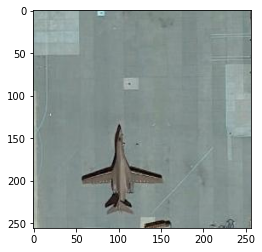

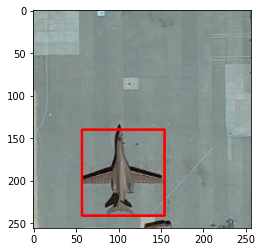

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# Selective Search

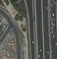

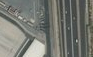

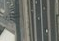

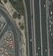

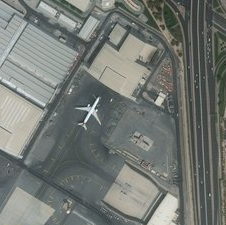

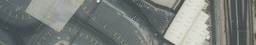

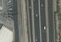

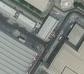

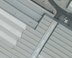

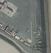

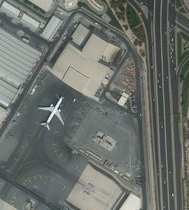

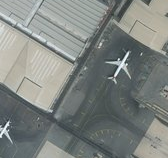

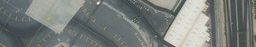

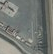

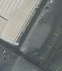

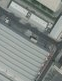

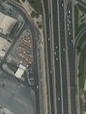

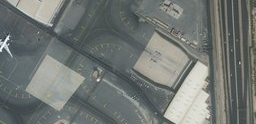

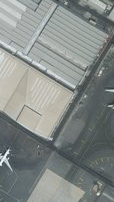

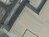

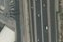

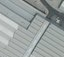

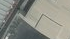

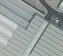

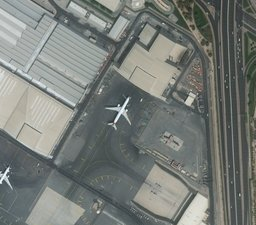

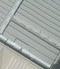

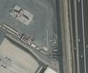

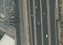

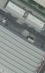

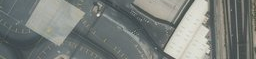

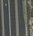

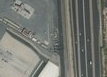

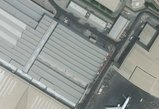

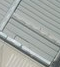

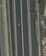

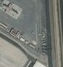

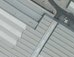

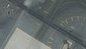

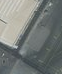

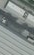

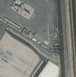

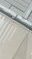

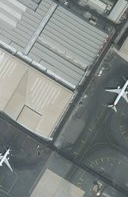

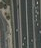

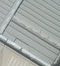

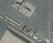

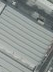

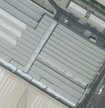

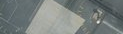

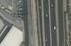

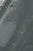

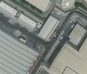

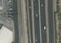

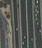

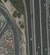

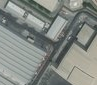

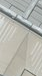

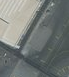

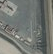

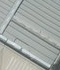

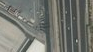

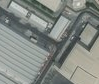

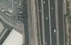

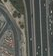

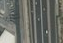

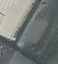

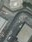

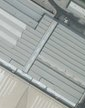

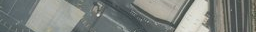

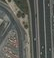

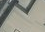

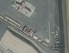

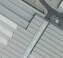

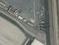

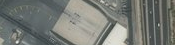

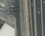

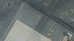

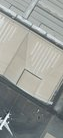

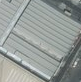

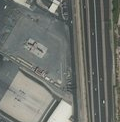

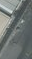

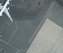

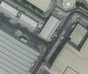

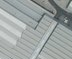

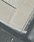

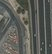

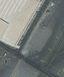

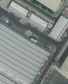

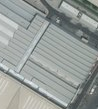

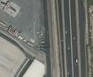

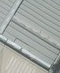

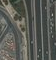

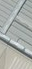

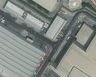

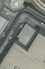

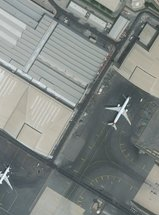

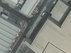

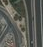

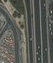

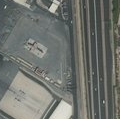

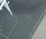

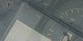

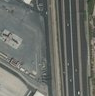

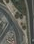

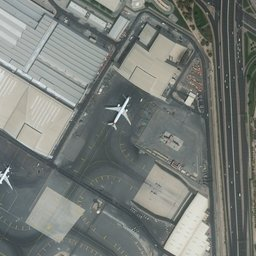

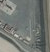

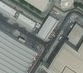

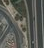

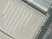

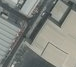

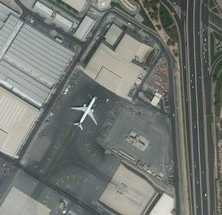

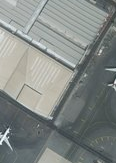

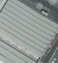

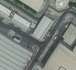

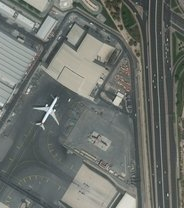

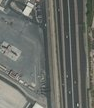

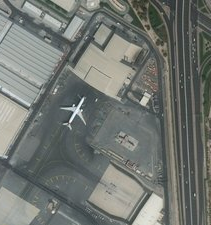

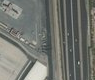

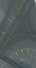

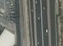

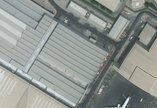

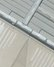

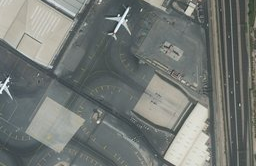

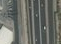

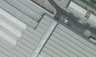

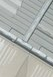

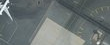

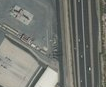

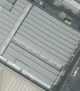

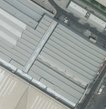

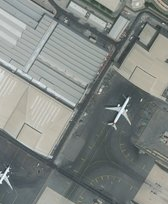

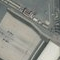

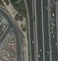

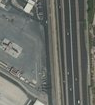

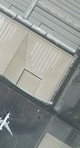

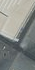

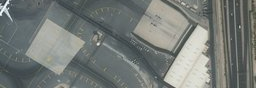

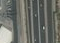

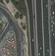

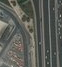

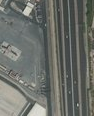

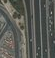

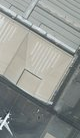

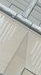

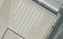

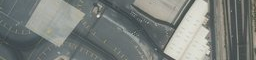

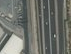

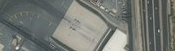

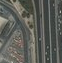

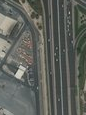

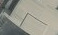

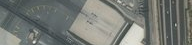

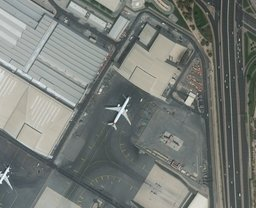

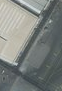

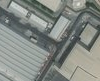

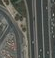

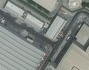

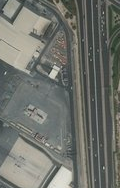

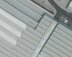

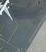

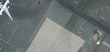

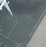

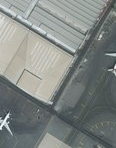

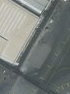

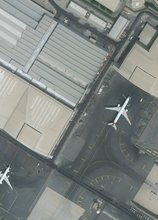

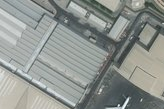

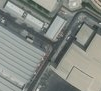

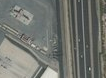

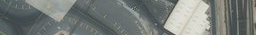

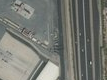

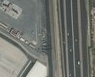

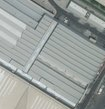

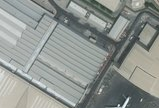

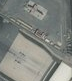

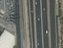

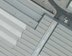

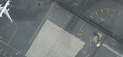

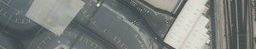

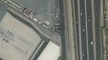

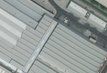

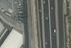

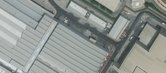

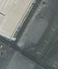

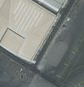

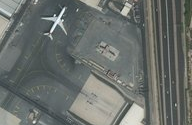

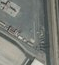

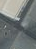

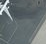

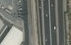

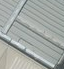

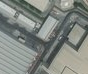

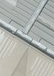

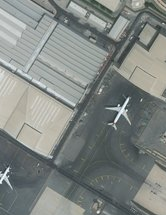

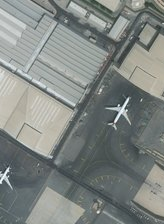

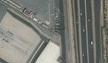

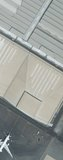

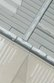

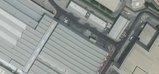

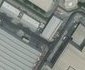

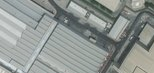

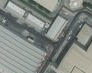

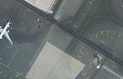

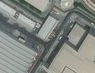

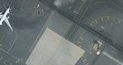

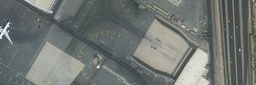

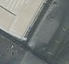

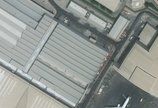

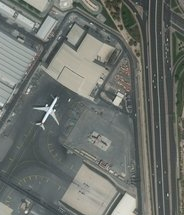

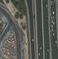

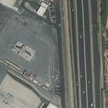

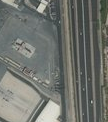

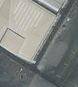

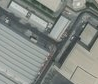

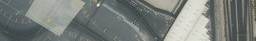

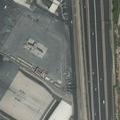

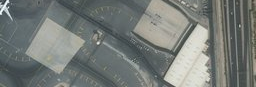

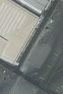

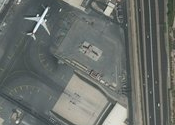

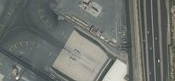

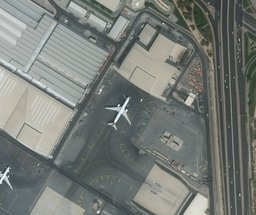

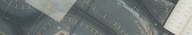

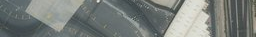

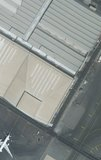

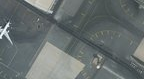

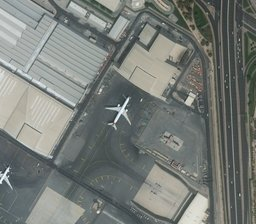

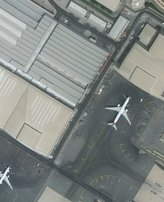

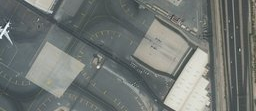

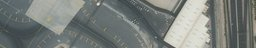

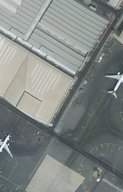

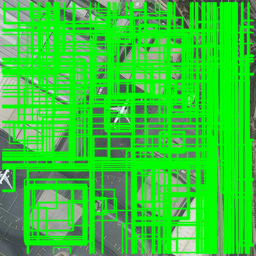

<Figure size 432x288 with 0 Axes>

In [ ]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    image = imOut[x:x+w,y:y+h]
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    cv2_imshow(image)
plt.figure()
cv2_imshow(im)

# IOU

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Selective Search Algorithm Pre-processing

In [ ]:
for m,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            image = cv2.imread(os.path.join(path,filename))
            filename = i.split(".")[0]+".jpg"
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                cv2.imwrite(airplane+filename+'_'+str(m)+'_'+str(e)+'.jpg', resized)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                cv2.imwrite(not_airplane+filename+'_'+str(m)+'_'+str(e)+'.jpg', resized)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

# Ram Issues

In [ ]:
import gc
gc.collect()

5823

# Train test split

In [ ]:
paths = [airplane+image for image in os.listdir(airplane)]+[airplane+image for image in os.listdir(not_airplane)]
classes = ['airplane']*len(os.listdir('/content/Data/Airplane'))+['not airplane']*len(os.listdir('/content/Data/Not Airplane'))

In [ ]:
main_df = pd.DataFrame()
main_df['classes'] = classes
main_df['path'] = paths

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(main_df[['path', 'classes']], main_df[['classes']], test_size=0.2, random_state=42)

# Data Generators

In [ ]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
)

Found 7568 validated image filenames belonging to 2 classes.
Found 1924 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 8902 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2194 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Modelling

In [ ]:
resnet50 = ResNet50(include_top = False, input_shape = (224,224,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(2, activation='softmax')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model_resnet50.compile(loss = keras.losses.categorical_crossentropy, optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [ ]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=50,
      verbose=2)

Epoch 1/50
237/237 - 244s - loss: 0.1885 - accuracy: 0.9430 - val_loss: 0.1051 - val_accuracy: 0.9802 - 244s/epoch - 1s/step
Epoch 2/50
237/237 - 294s - loss: 0.1129 - accuracy: 0.9781 - val_loss: 0.1027 - val_accuracy: 0.9802 - 294s/epoch - 1s/step
Epoch 3/50
237/237 - 327s - loss: 0.1134 - accuracy: 0.9781 - val_loss: 0.1025 - val_accuracy: 0.9802 - 327s/epoch - 1s/step
Epoch 4/50
237/237 - 309s - loss: 0.1124 - accuracy: 0.9781 - val_loss: 0.1102 - val_accuracy: 0.9802 - 309s/epoch - 1s/step
Epoch 5/50
237/237 - 307s - loss: 0.1073 - accuracy: 0.9781 - val_loss: 0.1019 - val_accuracy: 0.9802 - 307s/epoch - 1s/step
Epoch 6/50
237/237 - 317s - loss: 0.1100 - accuracy: 0.9781 - val_loss: 0.0971 - val_accuracy: 0.9802 - 317s/epoch - 1s/step
Epoch 7/50
237/237 - 323s - loss: 0.1061 - accuracy: 0.9781 - val_loss: 0.1002 - val_accuracy: 0.9802 - 323s/epoch - 1s/step
Epoch 8/50
237/237 - 309s - loss: 0.1056 - accuracy: 0.9781 - val_loss: 0.1041 - val_accuracy: 0.9802 - 309s/epoch - 1s/step


KeyboardInterrupt: ignored

In [ ]:
gc.collect(generation=2)

# Validation

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

# Prediction

In [ ]:
path = X_val['path']

/content/photo-1531642765602-5cae8bbbf285.jfif


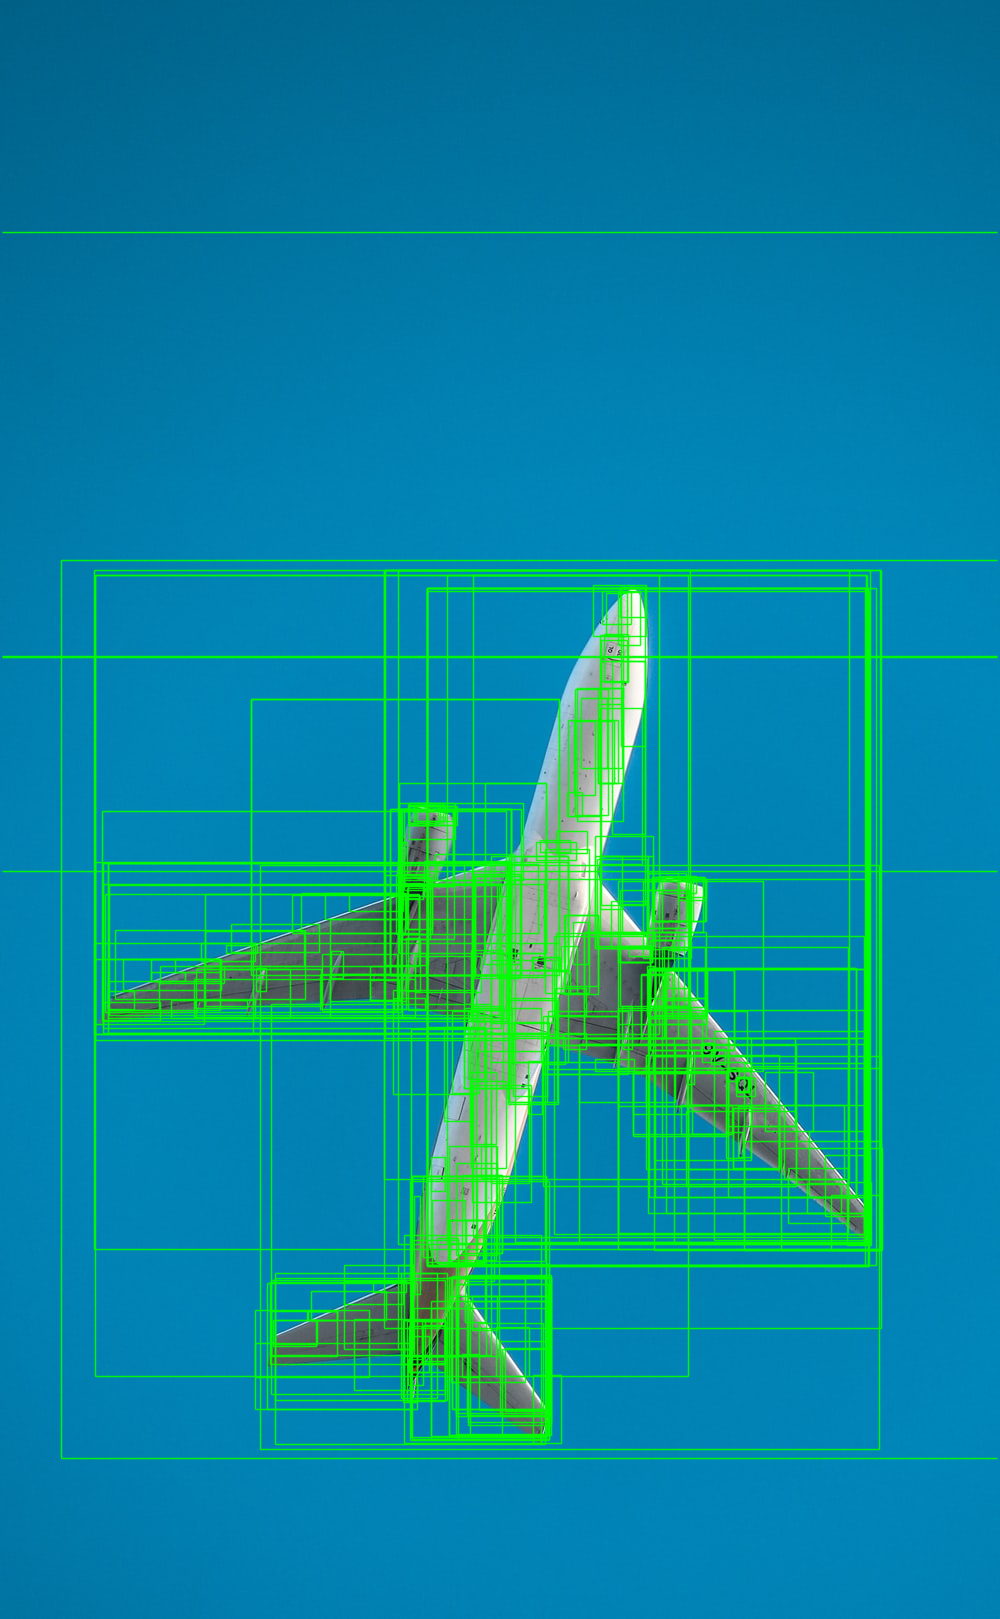

In [33]:
z=0
for e,i in enumerate(['/content/photo-1531642765602-5cae8bbbf285.jfif']):
    print(i)
    if cv2.imread(i) is not None:
        img = cv2.imread(i)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_resnet50.predict(img)
                if out[0][0] > 0.95:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        cv2_imshow(imout)
        break
        plt.figure()
        plt.imshow(imout)